In [1]:
from scipy.integrate import odeint
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
tf.version.VERSION # This verifies the version of Tensorflow.

'2.11.1'

In [3]:
## LORENZ PARAMETERS AND INITIAL CONDITIONS:
# The parameter rho shall have the values of 10, 28, and 40 (and later 17 and 35).

sigma = 10
rho = 28
beta = 8/3

x0 = 0
y0 = 1
z0 = 1

# The initial conditions were selected based on Christian Hill (2016) - https://scipython.com/blog/the-lorenz-attractor/.

In [4]:
## THE LORENZ EQUATIONS:

def Lorenz(X, t, simga, beta, rho):
    x,y,z = X 
    dxdt = -sigma * (x - y)
    dydt = x * (rho - z) - y
    dzdt = (x * y) - (beta * z)
    return dxdt, dydt, dzdt

In [5]:
# Maximum time point and total number of time points:

tmax = 100
n = 10000

# Interpolate solution onto the time grid, t:

t = np.linspace(0, tmax, n)

In [6]:
# Integrate the Lorenz equations:

sol = odeint(Lorenz,(x0, y0, z0),t,args=(sigma, beta, rho))

In [7]:
print(sol.shape)

# There are three columns: x, y, z.

(10000, 3)


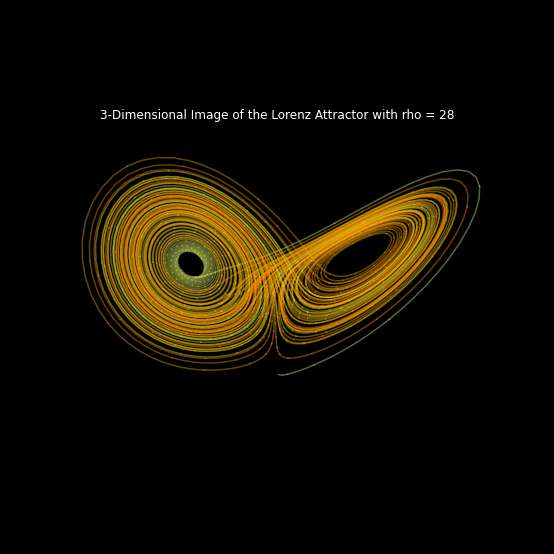

In [8]:
## CREATING THE IMAGE OF THE LORENZ ATTRACTOR:
# Based on Christian Hill (2016) - https://scipython.com/blog/the-lorenz-attractor/.
    
WIDTH, HEIGHT, DPI = 1000, 750, 100

fig = plt.figure(facecolor = 'k', figsize = (WIDTH/DPI, HEIGHT/DPI))
ax = plt.axes(projection='3d')
ax.set_facecolor('k')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

x = sol[:, 0]
y = sol[:, 1]
z = sol[:, 2]

s = 10

cmap = plt.cm.Wistia

for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n), alpha=0.4)

ax.set_axis_off()

plt.title("3-Dimensional Image of the Lorenz Attractor with rho = 28", color = "white", x = 0.5, y = 0.85)
plt.savefig('lorenz_28.png', dpi=DPI)
plt.show()

# Note: images of the attractor have been made for rho = 10, 28, 40.

In [9]:
## PARTICULAR SOLUTIONS: RHO = 10

rho = 10
sol10 = odeint(Lorenz,(x0, y0, z0),t,args=(sigma, beta, rho))
np.save("sol10", sol10)

In [10]:
## PARTICULAR SOLUTIONS: RHO = 28

rho = 28
sol28 = odeint(Lorenz,(x0, y0, z0),t,args=(sigma, beta, rho))
np.save("sol28", sol28)

In [11]:
## PARTICULAR SOLUTIONS: RHO = 40

rho = 40
sol40= odeint(Lorenz,(x0, y0, z0),t,args=(sigma, beta, rho))
np.save("sol40", sol40)

In [12]:
## DATA PROCESSING TO FEED THE MODEL: Merci, Nada !

mat10 = np.load("sol10.npy")
mat28 = np.load("sol28.npy")
mat40 = np.load("sol40.npy")

data = np.empty((30000, 4))
print(data.shape)

# Four columns, for x, y, z, and rho.

# Stacking all of our data from each rho into one single matrix:

data[0:10000, 0:3] = mat10
data[10000:20000, 0:3] = mat28
data[20000:30000, 0:3] = mat40
data[0:10000, 3:4] = 10
data[10000:20000, 3:4] = 28
data[20000:30000, 3:4] = 40

# Here we create matrices xn and xnp1 where xnp1 represents the forecast of xn one step into the future:
xn = np.empty((29997, 4))
xn[0:9999,0:4] = data[0:9999,0:4]
xn[9999:19998,0:4] = data[10000:19999,0:4]
xn[19998:29997,0:4] = data[20000:29999,0:4]

xnp1 = np.empty((29997,4))
xnp1[0:9999,0:4] = data[1:10000,0:4]
xnp1[9999:19998,0:4] = data[10001:20000,0:4]
xnp1[19998:29997,0:4] = data[20001:30000,0:4]

(30000, 4)


In [13]:
## DEFINING THE NEURAL NETWORK:

def init_model(num_hidden_layers = 4, num_neurons_per_layer = 80):
    
    # Initialize a feedforward neural network:
    
    model = tf.keras.Sequential()

    # Input is 2D - for each component of the Henon output:
    
    model.add(tf.keras.Input(4))

    # Append hidden layers:
    
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('relu'),
            kernel_initializer='glorot_normal'))

    # Output is 2D - for the next step of Henon map:
    
    model.add(tf.keras.layers.Dense(4))
    
    return model

In [14]:
## DEFINING THE LOSS FUNCTION:

def compute_loss(model, xn, xnp1, steps): 
    
    loss = 0
    
    xpred = model(xn)
        
    loss += tf.reduce_mean(tf.square(xpred - xnp1))

    return loss

In [15]:
## COMPUTING THE GRADIENT:

def get_grad(model, xn,xnp1, steps): 
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with respect to trainable variables.
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, xn,xnp1, steps)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [16]:
## INITIALIZE MODEL (TILDE U):

model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the step size in the gradient descent type algorithm.
# From 0 - 999, learning rate = 0.01; from 1000 - 3000, learning rate = 0.001; from 3000 onwards, learning rate = 0.0005.

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,1e-4])

# The learning rate is decreased along the way to decrease the size of the set, in order to ensure the minimum is not missed.

# Choose the optimizer:

optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [17]:
from time import time

steps = 4

# Define one training step as a TensorFlow function to increase speed of training:

@tf.function
def train_step():
    
    # Compute current loss and gradient with respect to parameters:
    
    loss, grad_theta = get_grad(model, xn, xnp1, steps)
    
    #Perform gradient descent step:
    
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs:

N = 10000
hist = []

# Start timer:

t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist:
    
    hist.append(loss.numpy())
    
    #Output current loss after 50 iterates:
    
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
#Print computation time:

print('Computation time: {} seconds'.format(time()-t0))

It 00000: loss = 4.10049927e+02
It 00050: loss = 5.39168775e-01
It 00100: loss = 6.16521463e-02
It 00150: loss = 3.15564014e-02
It 00200: loss = 2.31433101e-02
It 00250: loss = 2.35967115e-02
It 00300: loss = 1.72991827e-02
It 00350: loss = 1.48492614e-02
It 00400: loss = 1.36725262e-01
It 00450: loss = 1.51584949e-02
It 00500: loss = 1.25825768e-02
It 00550: loss = 1.50373355e-01
It 00600: loss = 1.37568414e-02
It 00650: loss = 1.10840965e-02
It 00700: loss = 9.94743034e-03
It 00750: loss = 1.12217975e+00
It 00800: loss = 1.70938913e-02
It 00850: loss = 9.67460405e-03
It 00900: loss = 8.56156182e-03
It 00950: loss = 1.90223567e-02
It 01000: loss = 8.30609072e-03
It 01050: loss = 7.98759609e-03
It 01100: loss = 7.88258761e-03
It 01150: loss = 7.78286019e-03
It 01200: loss = 7.68622244e-03
It 01250: loss = 7.59285875e-03
It 01300: loss = 7.50240032e-03
It 01350: loss = 7.41557404e-03
It 01400: loss = 7.33206701e-03
It 01450: loss = 7.25159701e-03
It 01500: loss = 7.17185671e-03
It 01550

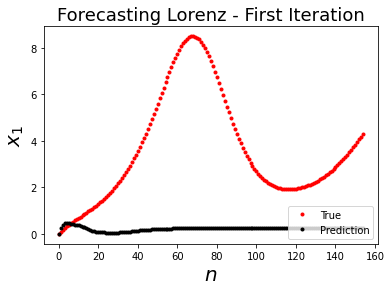

In [45]:
M = 1000

xpred = np.zeros((M,4))
xpred[0] = xn[0,:]

for m in range(1,M):
    xpred[m] = model(xpred[m-1:m,:])   
    
#Plot Henon Trajectories:

fig = plt.figure()
plt.plot(xn[:155,0],'r.', label = "True") 
plt.plot(xpred[:155,0],'k.', label = "Prediction") 
plt.title('Forecasting Lorenz - First Iteration', fontsize = 18)
plt.xlabel('$n$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20)  
plt.legend(loc = 'lower right', prop = {'size':10})
plt.savefig("Forecast 0")

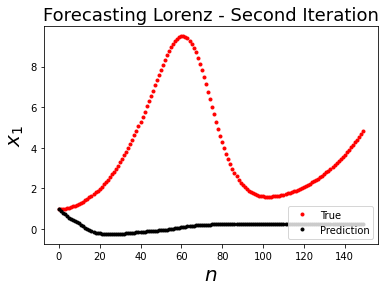

In [46]:
#Plot Henon Trajectories:

fig = plt.figure()
plt.plot(xn[:150,1],'r.', label = "True") 
plt.plot(xpred[:150,1],'k.', label = "Prediction") 
plt.title('Forecasting Lorenz - Second Iteration', fontsize = 18)
plt.xlabel('$n$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20) 
plt.legend(loc = 'lower right', prop = {'size':10})
plt.savefig("Forecast 1")

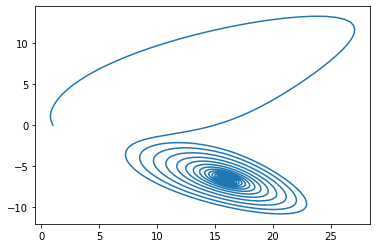

In [36]:
#Testing the other rho values:

rho = 17
sol4 = odeint(Lorenz,(x0, y0, z0),t,args=(sigma, beta, rho))
plt.plot(sol4[:,2], sol4[:, 0], label='x_coord')

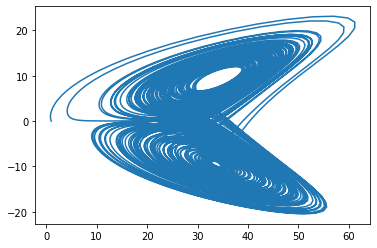

In [21]:
rho = 35
sol5 = odeint(Lorenz,(x0, y0, z0),t,args=(sigma, beta, rho))
plt.plot(sol5[:,2], sol5[:, 0], label='x_coord')

In [22]:
np.save('solutions_rho17', sol4)
np.save('solutions_rho35', sol5)

In [23]:
matrix_rho17=np.load('solutions_rho17.npy')
matrix_rho35=np.load('solutions_rho35.npy')

In [47]:
#rho 17 data
size_input = matrix_rho17.shape[0]*3
dataRho17 = np.empty((size_input,4))
dataRho17[0:10000,0:3] = matrix_rho17
dataRho17[0:10000,3:4] = 17

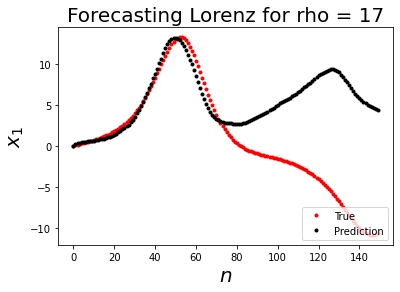

In [48]:
M = 10000

xpred = np.zeros((M,4))
xpred[0] = dataRho17[0,:]

for m in range(1,M):
    xpred[m] = model(xpred[m-1:m,:])   
    
#Plot Henon Trajectories for rho 17
fig = plt.figure()
plt.plot(dataRho17[:150,0],'r.', label = "True") 
plt.plot(xpred[:150,0],'k.', label = "Prediction") 
plt.title('Forecasting Lorenz for rho = 17', fontsize = 20)
plt.xlabel('$n$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20)
plt.legend(loc = 'lower right', prop = {'size':10})
plt.savefig("Forecast 17")

In [49]:
#rho 35 data
size_input = matrix_rho35.shape[0]*3
dataRho35 = np.empty((size_input,4))
dataRho35[0:10000,0:3] = matrix_rho35
dataRho35[0:10000,3:4] = 35

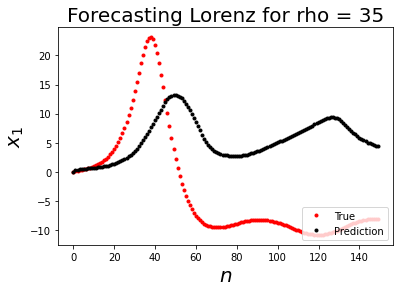

In [52]:
#Plot Henon Trajectories for rho 35
fig = plt.figure()
plt.plot(dataRho35[:150,0],'r.', label = "True") 
plt.plot(xpred[:150,0],'k.', label = "Prediction") 
plt.title('Forecasting Lorenz for rho = 35', fontsize = 20)
plt.xlabel('$n$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20)  
plt.legend(loc = 'lower right', prop = {'size':10})
plt.savefig("Forecast 35")

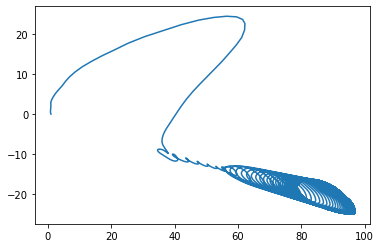

In [28]:
#Plot of rho 35 data
plt.plot(xpred[:,2], xpred[:, 0], label='x_coord')

Text(0, 0.5, '$x_1$')

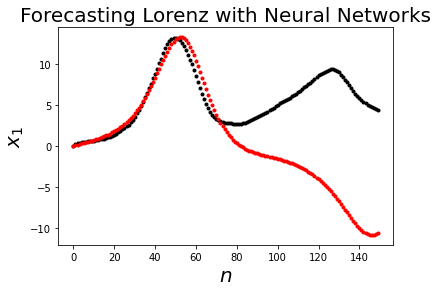

In [29]:
M = 10000

xpred = np.zeros((M,4))
xpred[0] = dataRho17[0,:]

for m in range(1,M):
    xpred[m] = model(xpred[m-1:m,:])   
    
#Plot Henon Trajectories for rho 17
fig = plt.figure()
plt.plot(xpred[:150,0],'k.') 
plt.plot(dataRho17[:150,0],'r.') 
plt.title('Forecasting Lorenz with Neural Networks', fontsize = 20)
plt.xlabel('$n$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20)

Text(0, 0.5, '$x_1$')

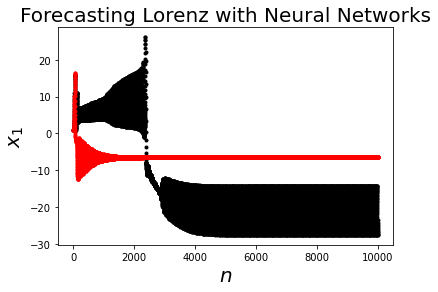

In [30]:
#Plot Henon Trajectories
fig = plt.figure()
plt.plot(xpred[:10000,1],'k.') 
plt.plot(dataRho17[:10000,1],'r.') 
plt.title('Forecasting Lorenz with Neural Networks', fontsize = 20)
plt.xlabel('$n$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20) 

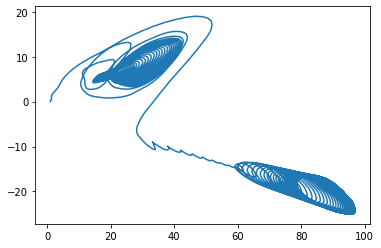

In [31]:
#Plot of rho 17 data
plt.plot(xpred[:,2], xpred[:, 0], label='x_coord')